In [1]:
from PIL import Image, ImageDraw
from io import BytesIO
import json
import joblib
import os
import requests
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import feature as skif

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

random.seed(25)

In [132]:
class ColorMNIST_LT(torchvision.datasets.MNIST):
    def __init__(self, phase, test_type, output_path, logger, cat_ratio=1.0, att_ratio=0.1):
        super(ColorMNIST_LT, self).__init__(root='./', train=(phase == 'train'), download=True)
        # mnist dataset contains self.data, self.targets
        self.dig2label = {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2}
        self.dig2attri = {}
        self.colors = {0:[1,0,0], 1:[0,1,0], 2:[0,0,1]}
        
        self.cat_ratio = cat_ratio
        self.att_ratio = att_ratio
        # generate long-tailed data
        self.generate_lt_label(cat_ratio)
        
        
    def generate_lt_label(self, ratio=1.0):
        self.label2list = {i:[] for i in range(3)}
        for img, dig in zip(self.data, self.targets):
            label = self.dig2label[int(dig)]
            self.label2list[label].append(img)
        if ratio == 1.0:
            balance_size = min([len(val) for key, val in self.label2list.items()])
            for key, val in self.label2list.items():
                self.label2list[key] = val[:balance_size]
        elif ratio < 1.0:
            current_size = len(self.label2list[0])
            for key, val in self.label2list.items():
                max_size = len(val)
                self.label2list[key] = val[:min(max_size, current_size)]
                current_size = int(current_size * ratio)
        else:
            raise ValueError('Wrong Ratio in ColorMNIST')
        
        self.lt_labels = []
        self.lt_imgs = []
        for key, val in self.label2list.items():
            for item in val:
                self.lt_labels.append(key)
                self.lt_imgs.append(item)
            print('Generate ColorMNIST: label {} has {} images.'.format(key, len(val)))
        
                
    def __len__(self):
        return len(self.lt_labels)
        
    def __getitem__(self, index):
        img = self.lt_imgs[index].unsqueeze(-1).repeat(1,1,3)
        label = self.lt_labels[index]
        
        # generate tail colors
        if random.random() < self.att_ratio:
            att_label = random.randint(0,2)
            color = self.colors[att_label]
        else:
            color = self.colors[label]
        
        # assign attribute
        img = self.to_color(img, color)
        
        return img, label
    
    def to_color(self, img, rgb=[1,0,0]):
        return (img * torch.FloatTensor(rgb).unsqueeze(0).unsqueeze(0)).byte()

In [133]:
def visualization(input_tensor):
    return Image.fromarray(input_tensor.numpy()).resize((64,64))

In [135]:
dataset = ColorMNIST_LT('train', 'test_iid', '.', None, 0.1, 0.1)

Generate ColorMNIST: label 0 has 24754 images.
Generate ColorMNIST: label 1 has 2475 images.
Generate ColorMNIST: label 2 has 247 images.


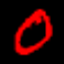

In [165]:
visualization(dataset[0][0])